# NDVI data

in this notebook are explored the extracted NDVI data from google earth engine. some data exploration and cleaning and then the point is to overlay the NDVI values with hex grid finding the NDVI value and  the mean, max, min and std of every trajectory. 
(the data have been extracted using Urban Walk - Lisbon 2024/2.NDVI_LISBON_GEE.js file in google engine)

**Normalized Difference Vegetation Index (NDVI)**

The **NDVI** is a spectral index used to measure vegetation health and density, defined as:


$$
NDVI = \frac{NIR - RED}{NIR + RED}
$$


Where:
- **NIR** = Reflectance in the near-infrared band  
- **RED** = Reflectance in the red band  

What it means:
- Satellites (like Sentinel-2 or Landsat) detect the light coming from every point on Earth in different spectral bands — kind of like taking photos through different color filters.
- Two of these bands are especially important for understanding how green and vegetated an area is:
    - RED → the visible red light (plants absorb it for photosynthesis)
    - NIR → the near-infrared light (healthy plants reflect it strongly)

How the formula works:
- If an area is very green, it reflects a lot of NIR and absorbs a lot of red →
NIR >> RED → NDVI close to 1
- If an area is bare or dry, it reflects little NIR and some red →
NIR ≈ RED → NDVI close to 0
- If it’s water or clouds, it reflects more red than NIR →
NIR < RED → NDVI is negative

Values range from **-1 to +1**:
- 🌊 **< 0** → Water, snow, or clouds  
- 🌾 **0 to 0.3** → Bare soil or sparse vegetation  
- 🌳 **0.3 to 0.8** → Moderate to dense vegetation  
- 🌲 **> 0.8** → Very dense vegetation


In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.plot import show 
from rasterstats import zonal_stats # for zoanl statistics
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import pickle

In [2]:
folder = "/mnt/raid/matteo/GEE_Exports_great_area/" # data saved in raid

# Find all NDVI files (sorted by month)
tif_files = sorted(glob.glob(os.path.join(folder, "NDVI_*.tif")))

print("Found files:", tif_files)

Found files: ['/mnt/raid/matteo/GEE_Exports_great_area/NDVI_2023_10.tif', '/mnt/raid/matteo/GEE_Exports_great_area/NDVI_2023_11.tif', '/mnt/raid/matteo/GEE_Exports_great_area/NDVI_2023_12.tif', '/mnt/raid/matteo/GEE_Exports_great_area/NDVI_2024_01.tif', '/mnt/raid/matteo/GEE_Exports_great_area/NDVI_2024_02.tif', '/mnt/raid/matteo/GEE_Exports_great_area/NDVI_2024_03.tif', '/mnt/raid/matteo/GEE_Exports_great_area/NDVI_2024_04.tif', '/mnt/raid/matteo/GEE_Exports_great_area/NDVI_2024_05.tif', '/mnt/raid/matteo/GEE_Exports_great_area/NDVI_2024_06.tif', '/mnt/raid/matteo/GEE_Exports_great_area/NDVI_2024_07.tif', '/mnt/raid/matteo/GEE_Exports_great_area/NDVI_2024_08.tif']


In [3]:
ndvi_stack = []

for f in tif_files:
    with rasterio.open(f) as src:
        ndvi = src.read(1).astype(float)
        ndvi[ndvi == src.nodata] = np.nan  # Replace nodata with NaN
        ndvi_stack.append(ndvi)

ndvi_stack = np.array(ndvi_stack)
print("NDVI stack shape:", ndvi_stack.shape)  # (5, height, width)


NDVI stack shape: (11, 7424, 12698)


In [4]:
print(ndvi_stack[0])

[[        nan  0.00053277 -0.00692841 ...         nan         nan
          nan]
 [        nan -0.0175146  -0.02635307 ...         nan         nan
          nan]
 [        nan  0.00237812  0.01155906 ...         nan         nan
          nan]
 ...
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]]


In [5]:
ndvi_files = sorted([f for f in os.listdir(folder) if f.startswith("NDVI_") and f.endswith(".tif")])

for i in range(len(ndvi_stack)):
    total = ndvi_stack[i].size
    n_nan = np.isnan(ndvi_stack[i]).sum()
    print(f"Month {ndvi_files[i].split('_')[2].replace('.tif', '')}: {total} total pixels")
    print(f"Month {ndvi_files[i].split('_')[2].replace('.tif', '')}: {n_nan} NaN pixels")
    print(f"Month {ndvi_files[i].split('_')[2].replace('.tif', '')}: {n_nan/total:.2%} NaN pixels")

Month 10: 94269952 total pixels
Month 10: 59098156 NaN pixels
Month 10: 62.69% NaN pixels
Month 11: 94269952 total pixels
Month 11: 67317059 NaN pixels
Month 11: 71.41% NaN pixels
Month 12: 94269952 total pixels
Month 12: 59023206 NaN pixels
Month 12: 62.61% NaN pixels
Month 01: 94269952 total pixels
Month 01: 59025189 NaN pixels
Month 01: 62.61% NaN pixels
Month 02: 94269952 total pixels
Month 02: 63380489 NaN pixels
Month 02: 67.23% NaN pixels
Month 03: 94269952 total pixels
Month 03: 59033005 NaN pixels
Month 03: 62.62% NaN pixels
Month 04: 94269952 total pixels
Month 04: 59026254 NaN pixels
Month 04: 62.61% NaN pixels
Month 05: 94269952 total pixels
Month 05: 59021796 NaN pixels
Month 05: 62.61% NaN pixels
Month 06: 94269952 total pixels
Month 06: 59022211 NaN pixels
Month 06: 62.61% NaN pixels
Month 07: 94269952 total pixels
Month 07: 59023883 NaN pixels
Month 07: 62.61% NaN pixels
Month 08: 94269952 total pixels
Month 08: 59021852 NaN pixels
Month 08: 62.61% NaN pixels


In [6]:
for fname in ndvi_files:
    with rasterio.open(os.path.join(folder, fname)) as src:
        arr = src.read(1)
        year = fname.split("_")[1]
        month = fname.split("_")[2].replace(".tif", "")
        print(f"Year {year}, Month {month}:")
        print("Min:", np.nanmin(arr))
        print("Max:", np.nanmax(arr))
        print("Mean:", np.nanmean(arr))
        print("Std:", np.nanstd(arr))
        print("Data type:", src.dtypes)
        print("-" * 30)

Year 2023, Month 10:
Min: -1.0
Max: 1.0
Mean: 0.61697465
Std: 0.26460505
Data type: ('float32',)
------------------------------
Year 2023, Month 11:
Min: -1.0
Max: 1.0
Mean: 0.3368189
Std: 0.26980343
Data type: ('float32',)
------------------------------
Year 2023, Month 12:
Min: -1.0
Max: 1.0
Mean: 0.36289176
Std: 0.19186573
Data type: ('float32',)
------------------------------
Year 2024, Month 01:
Min: -0.8202765
Max: 1.0
Mean: 0.12777166
Std: 0.15456073
Data type: ('float32',)
------------------------------
Year 2024, Month 02:
Min: -1.0
Max: 1.0
Mean: 0.41611168
Std: 0.25324228
Data type: ('float32',)
------------------------------
Year 2024, Month 03:
Min: -0.60363084
Max: 0.92020375
Mean: 0.4088054
Std: 0.18330374
Data type: ('float32',)
------------------------------
Year 2024, Month 04:
Min: -1.0
Max: 1.0
Mean: 0.5206843
Std: 0.23879386
Data type: ('float32',)
------------------------------
Year 2024, Month 05:
Min: -0.740113
Max: 0.95921075
Mean: 0.6419666
Std: 0.2838279
Data

In [7]:
print(ndvi_files)

['NDVI_2023_10.tif', 'NDVI_2023_11.tif', 'NDVI_2023_12.tif', 'NDVI_2024_01.tif', 'NDVI_2024_02.tif', 'NDVI_2024_03.tif', 'NDVI_2024_04.tif', 'NDVI_2024_05.tif', 'NDVI_2024_06.tif', 'NDVI_2024_07.tif', 'NDVI_2024_08.tif']


In [8]:
for i in range(len(ndvi_stack)):
    print('how many -1 in month,' ,ndvi_files[i].split("_")[2].replace(':tif', ""), ':', len(ndvi_stack[i][ndvi_stack[i] == -1]))

how many -1 in month, 10.tif : 4
how many -1 in month, 11.tif : 68502
how many -1 in month, 12.tif : 12
how many -1 in month, 01.tif : 0
how many -1 in month, 02.tif : 74945
how many -1 in month, 03.tif : 0
how many -1 in month, 04.tif : 2
how many -1 in month, 05.tif : 0
how many -1 in month, 06.tif : 131
how many -1 in month, 07.tif : 102752
how many -1 in month, 08.tif : 0


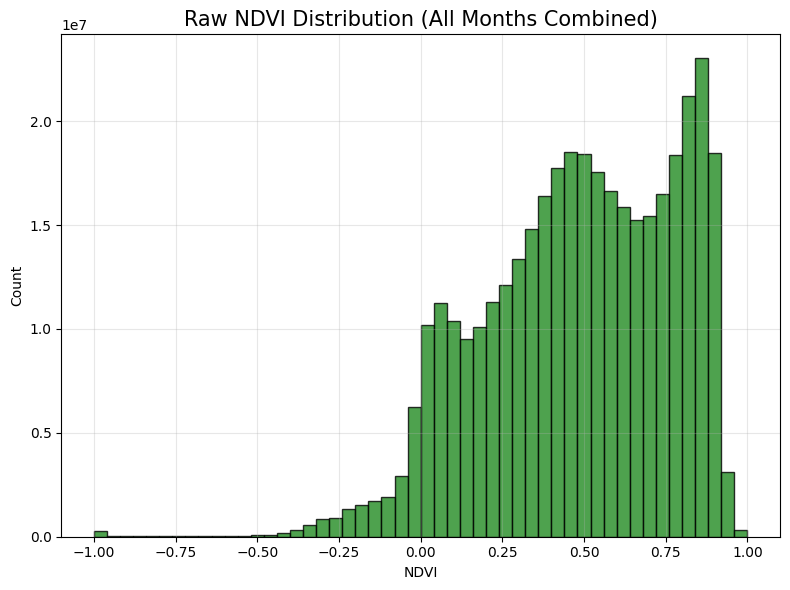

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Flatten all NDVI rasters into one long array
all_ndvi = np.concatenate([arr.flatten() for arr in ndvi_stack])
all_ndvi = all_ndvi[~np.isnan(all_ndvi)]   # remove NAN

plt.figure(figsize=(8,6))
plt.hist(all_ndvi, bins=50, color="forestgreen", edgecolor="black", alpha=0.8)
plt.title("Raw NDVI Distribution (All Months Combined)", fontsize=15)
plt.xlabel("NDVI")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

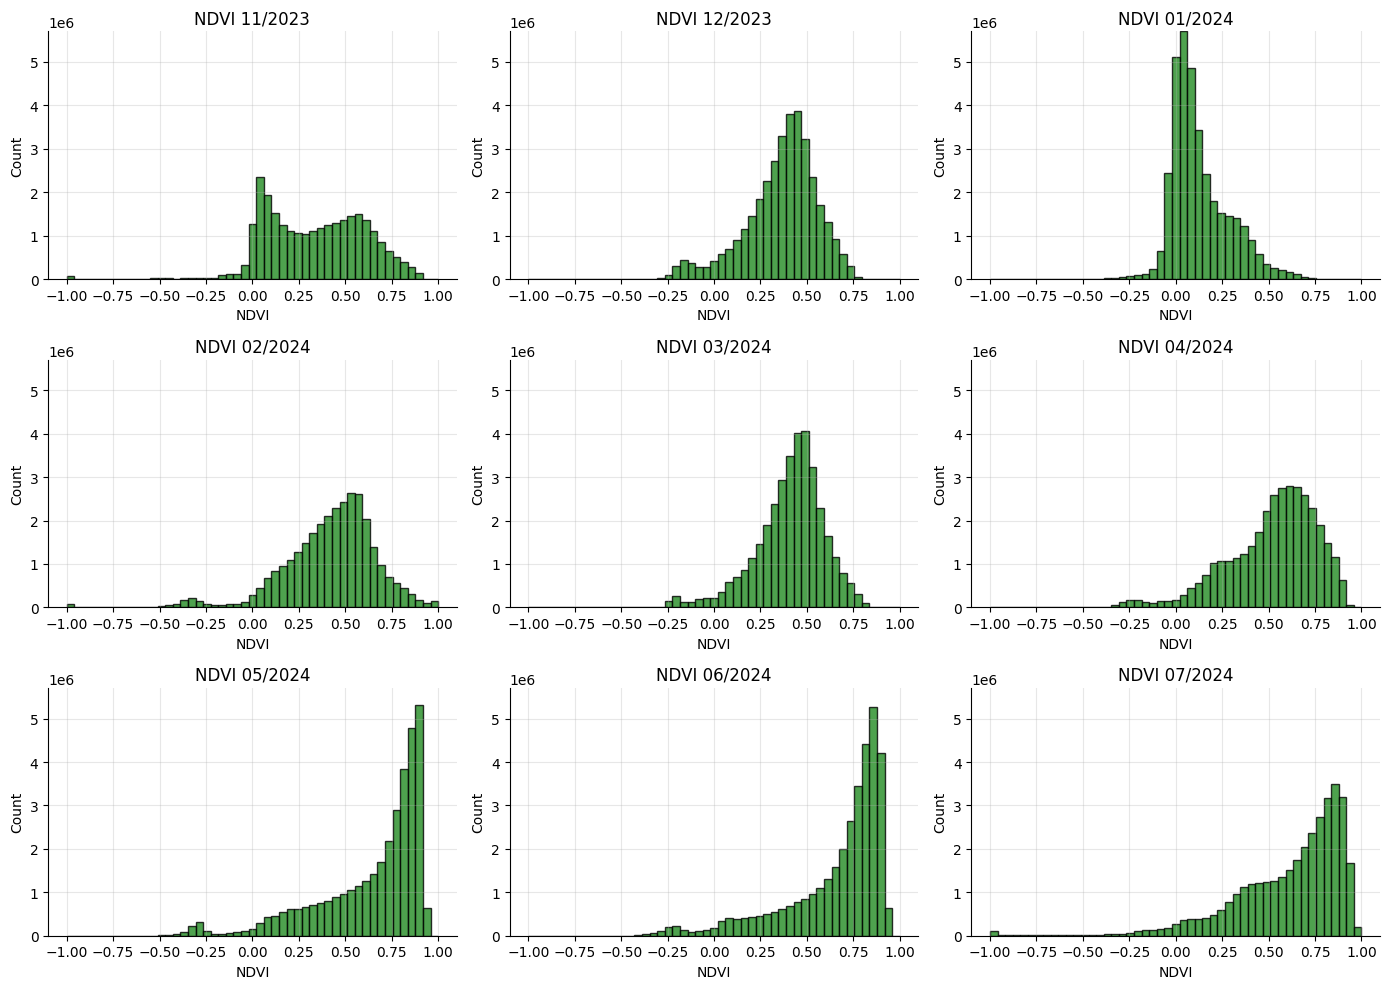

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# --- Step 1: Build a list with parsed info ---
parsed = []

for arr, fname in zip(ndvi_stack, ndvi_files):
    base = fname.replace(".tif", "")
    _, y, m = base.split("_")  # NDVI_YYYY_MM
    y = int(y)
    m = int(m)
    parsed.append({
        "year": y,
        "month": m,
        "ndvi": arr,
        "label": f"{m:02d}/{y}"
    })

# --- Step 2: Keep ONLY Nov 2023 → Jul 2024 ---
wanted = [
    (2023, 11),
    (2023, 12),
    (2024, 1),
    (2024, 2),
    (2024, 3),
    (2024, 4),
    (2024, 5),
    (2024, 6),
    (2024, 7)
]

selected = [p for p in parsed if (p["year"], p["month"]) in wanted]

# Sort chronologically
selected = sorted(selected, key=lambda x: (x["year"], x["month"]))

# --- Step 3: Determine global max count for unified y-axis ---
bins = np.linspace(-1, 1, 50)
max_count = 0

for p in selected:
    values = p["ndvi"].flatten()
    values = values[~np.isnan(values)]
    counts, _ = np.histogram(values, bins=bins)
    max_count = max(max_count, counts.max())

# --- Step 4: Plot 3×3 grid ---
fig, axes = plt.subplots(3, 3, figsize=(14, 10))
axes = axes.flatten()

for ax, p in zip(axes, selected):
    values = p["ndvi"].flatten()
    values = values[~np.isnan(values)]
    
    ax.hist(values, bins=bins, color="forestgreen", edgecolor="black", alpha=0.8)
    ax.set_ylim(0, max_count)
    ax.set_title(f"NDVI {p['label']}", fontsize=12)
    ax.set_xlabel("NDVI")
    ax.set_ylabel("Count")
    ax.grid(alpha=0.3)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# remove any empty subplots (shouldn't happen as len(selected)=9)
for i in range(len(selected), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


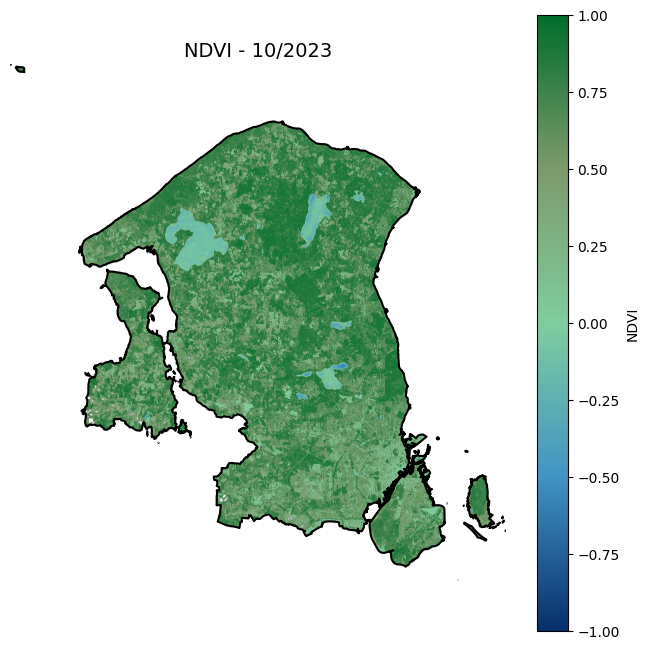

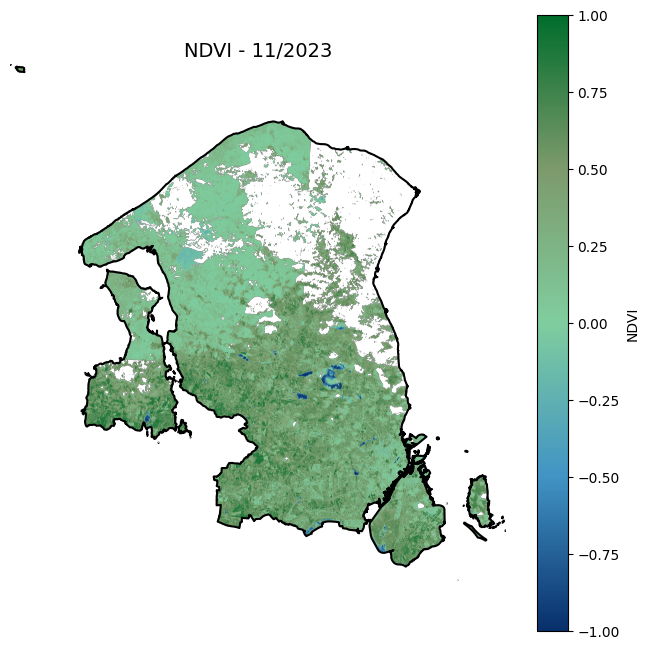

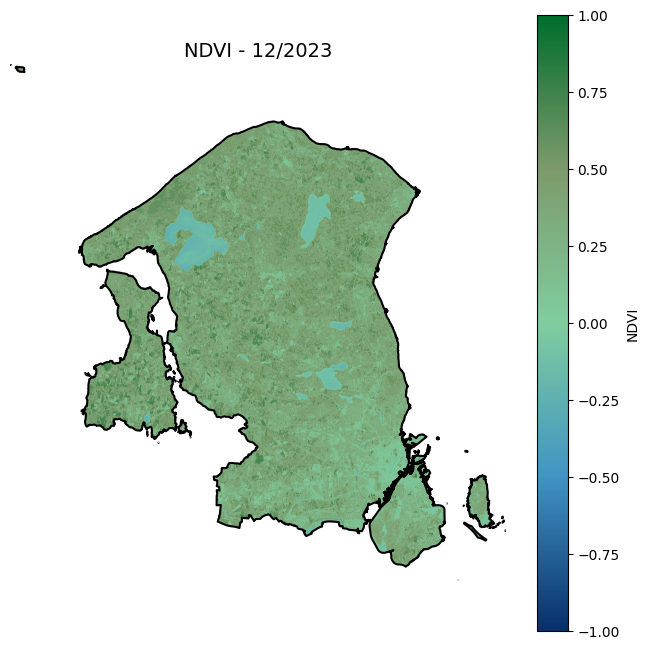

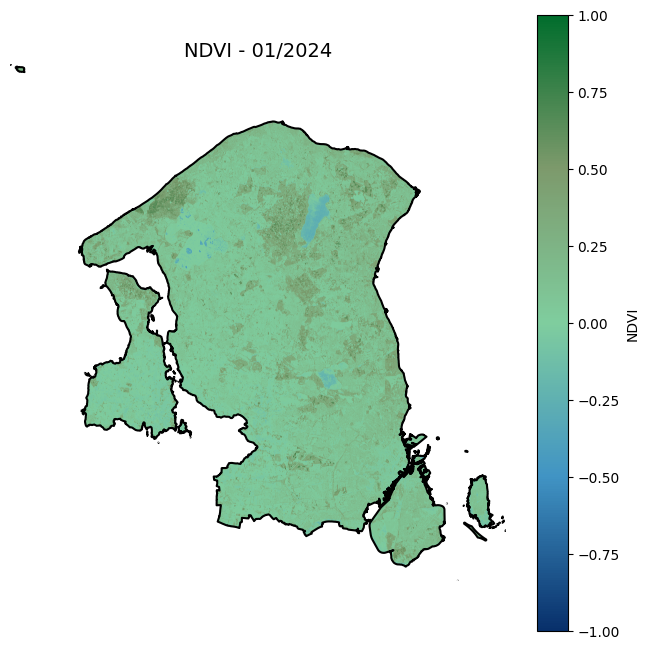

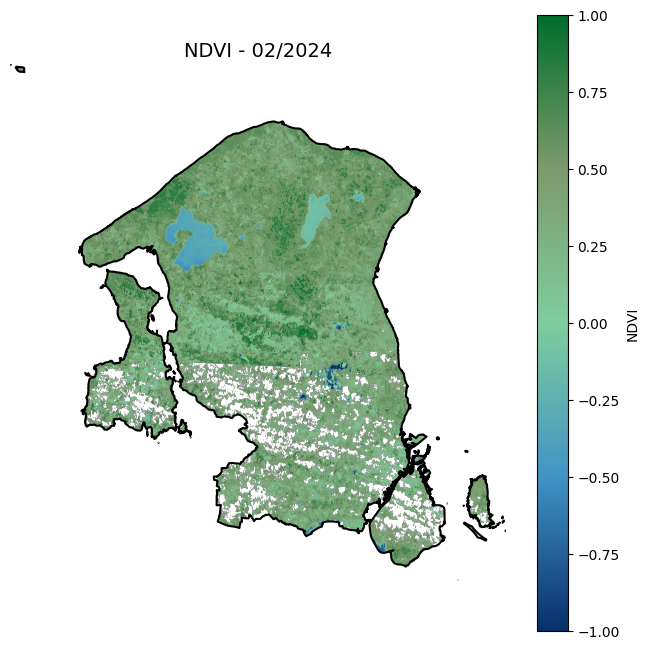

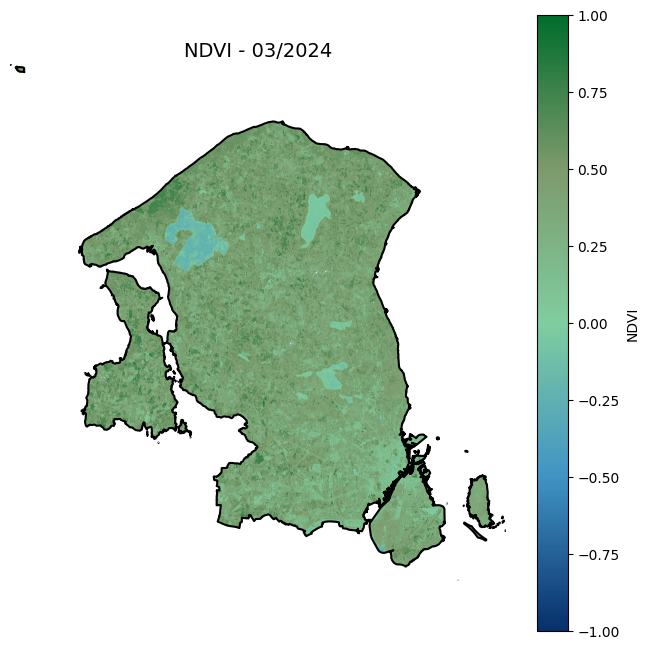

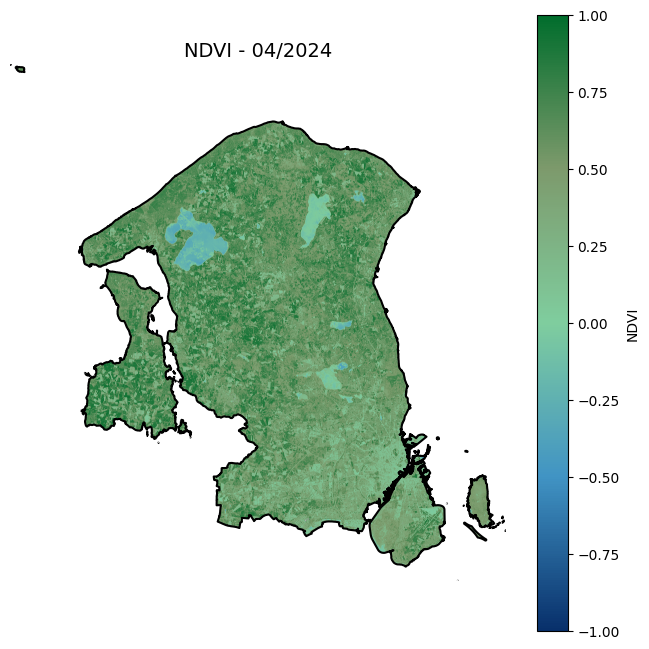

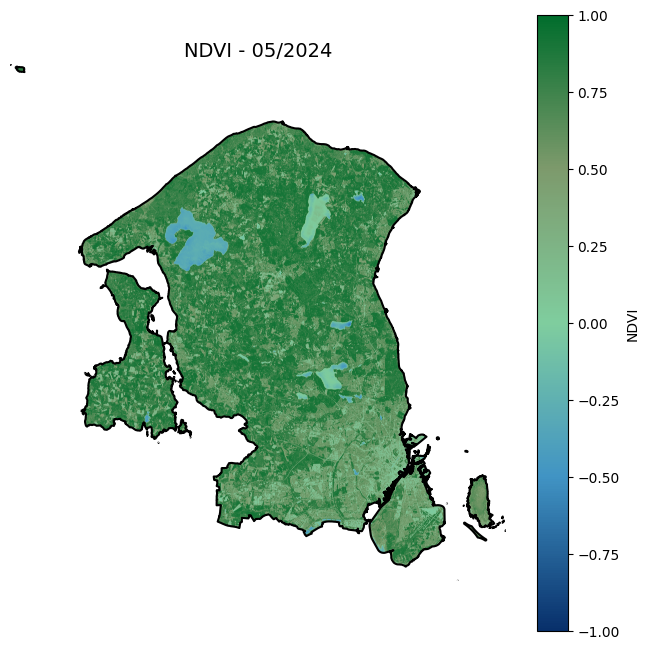

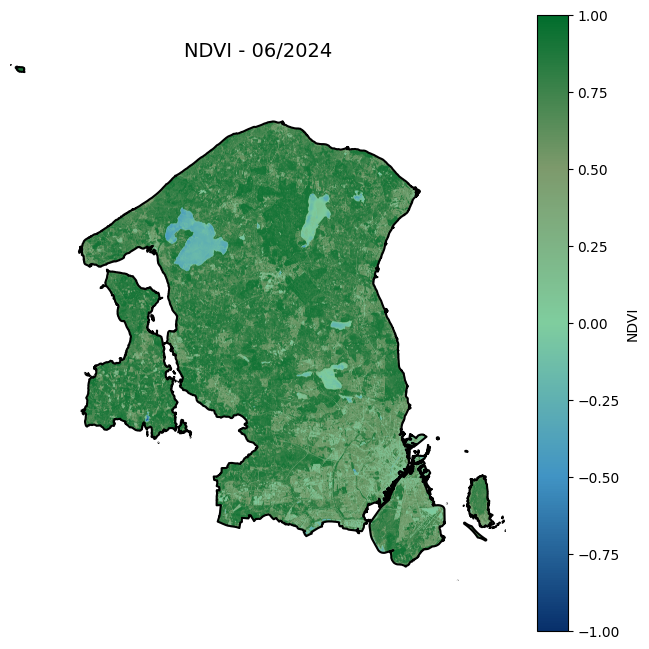

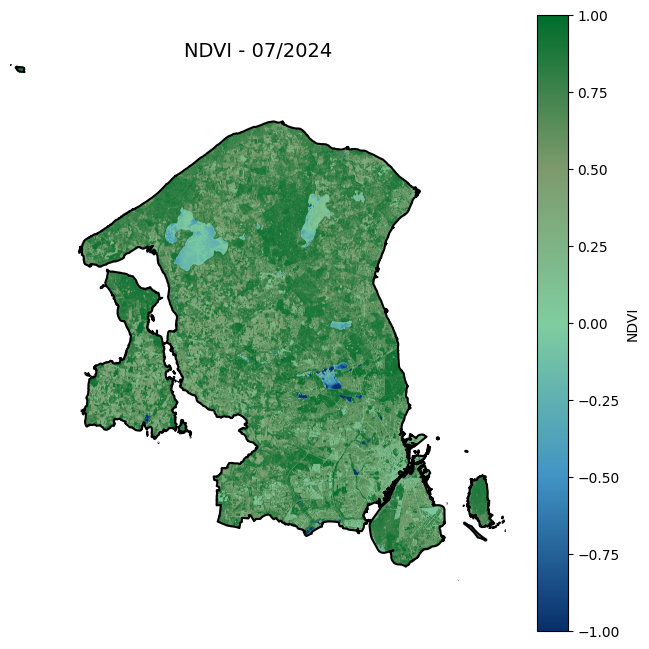

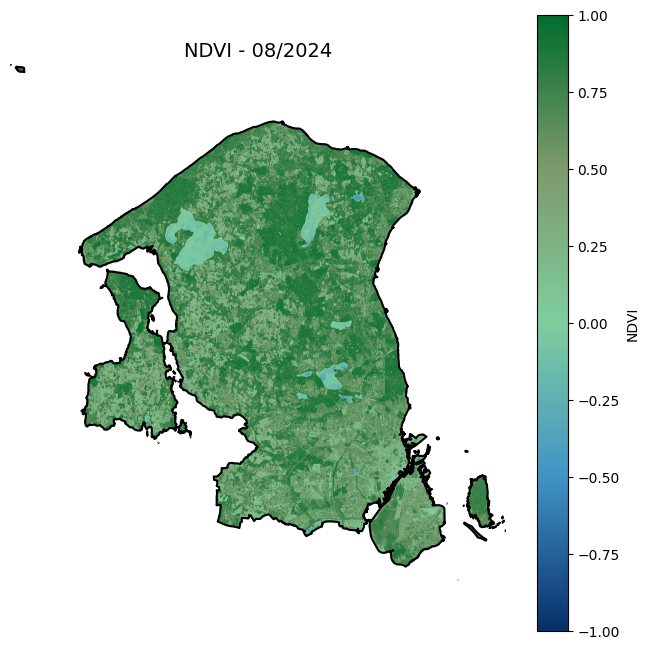

In [11]:
boundary_path = "/home/s232713/data/grid_data/copenhagen_union_boundary.geojson"  # boundary file

cph = gpd.read_file(boundary_path)

tif_files = sorted(glob.glob(os.path.join(folder, "NDVI_*.tif")))

# --- Plot each NDVI raster on top of the boundary ---
for i, tif_path in enumerate(tif_files):
    month = i + 8  # assuming files are Aug–Dec (8–12)

    with rasterio.open(tif_path) as src:
        fig, ax = plt.subplots(figsize=(8, 8))

        # Plot NDVI
        ndvi = src.read(1).astype(float)
        # ndvi[ndvi == -1] = float('nan')  # clean if necessary
        colors = ["#08306B", "#4194C4", "#7FCD9E", "#7D9A6C", "#006D2C"] # custom colormap
        blue_green = LinearSegmentedColormap.from_list("BlueGreen", colors)
        img = show(ndvi, transform=src.transform, ax=ax, cmap=blue_green, vmin=-1, vmax=1)

        # Plot Copenhagen boundary
        cph.boundary.plot(ax=ax, edgecolor='black', linewidth=1.5)

        # Title, colorbar, layout
        month_label = ndvi_files[i].split("_")[2].replace(".tif", "")
        year_label = ndvi_files[i].split("_")[1].replace(".tif", "")
        plt.title(f"NDVI - {month_label}/{year_label}", fontsize=14)
        plt.colorbar(img.get_images()[0], ax=ax, label='NDVI')
        plt.axis('off')

        plt.show()

        outpath = f"/home/s232713/figures/NDVI_{year_label}_{month_label}.pdf"
        fig.savefig(
            outpath,
            format="pdf",
            bbox_inches="tight"
        )

        plt.close(fig)



In [12]:
# INTERPOLATE NaN VALUES ACROSS MONTHS (linear between months)
T, H, W = ndvi_stack.shape # T=months, H=image height, W=image width
t = np.arange(T) # t array of time indices [0,...,T-1] used as x-axis for interpolation

# Make a copy to fill
ndvi_filled = ndvi_stack.copy()

for i in range(H):
    for j in range(W):
        y = ndvi_stack[:, i, j]
        ok = ~np.isnan(y) # mask of valid month 
        if ok.sum() >= 2: # interpolate only if i have 2 or more points to use
            ndvi_filled[~ok, i, j] = np.interp(t[~ok], t[ok], y[ok])
        # if less than 2 valid points leave as NaN (no interpolation possible)

print("Interpolation done! New stack shape:", ndvi_filled.shape)


Interpolation done! New stack shape: (11, 7424, 12698)


here interpolation has been done to fill up the NaN values in order to have a more consinstent NDVI dataset. the data from October 2023 and august 2024 has been extracted as well in order to have a proper interpolation of the months consideredn in the analysis (November 2023-July 2024). this prosess avoids a "fake" interpolation of the first month that just copied the first available pixel value due to .interp. 

the interpolation is done per pixel over time not across neighboring pixels, and it requires at leat 2 valid pixels to interpolate between. Like this it can interpolate also if i have consecutives NaN valuers across mutiple months goving a good apporximation of that pixel value due to the use of piecewise linear segments connecting all months. 

to calculate the interpolation of a point y* it uses the following relation: 

$$
\hat{y}(t^*) = y_1 + (y_2 - y_1)\,\frac{(t^* - t_1)}{(t_2 - t_1)}
$$


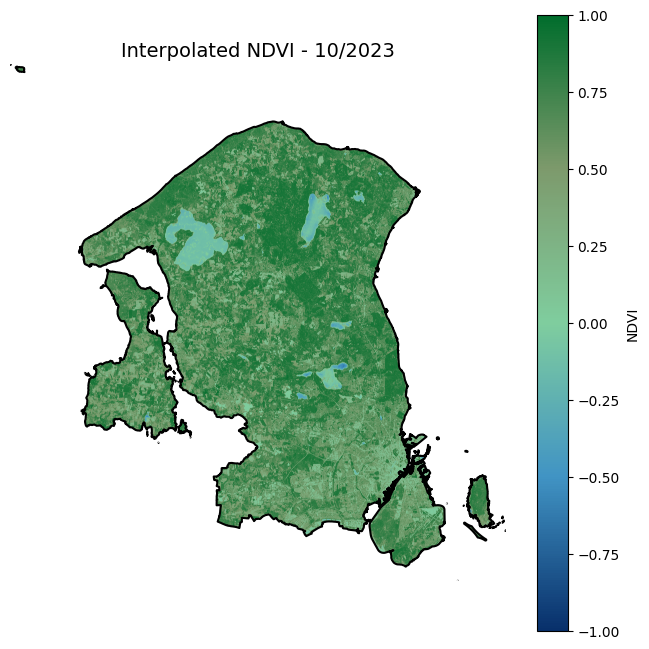

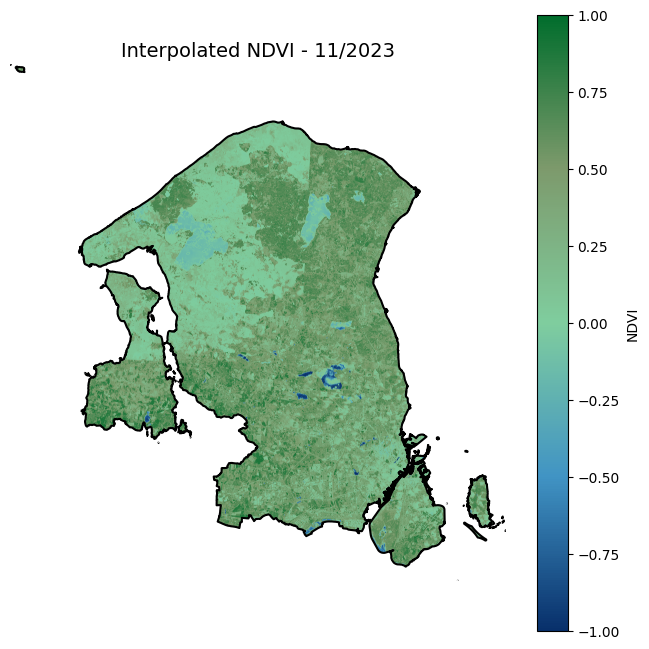

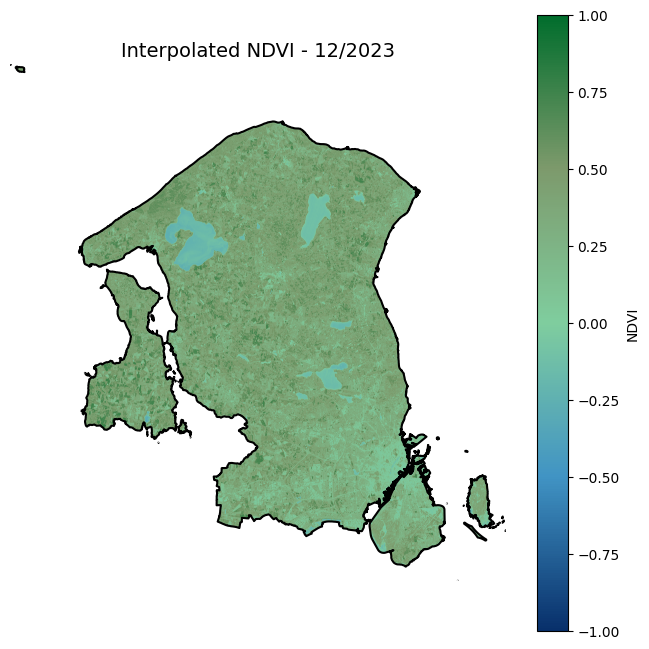

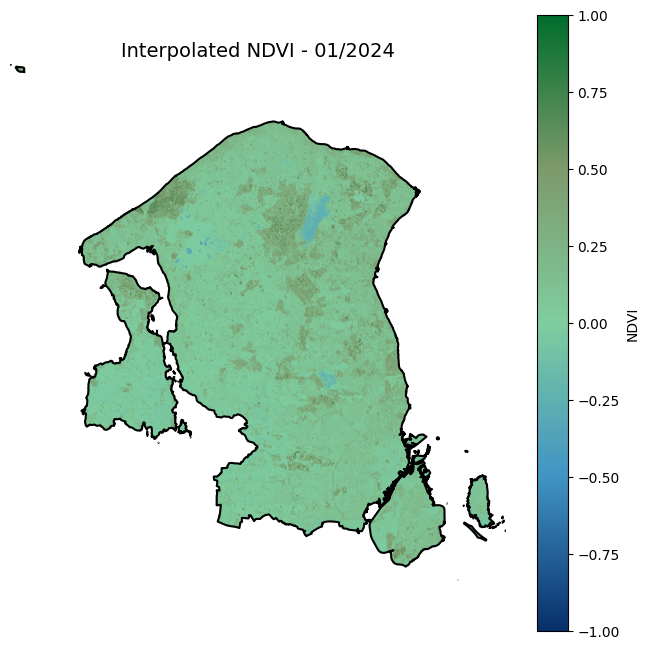

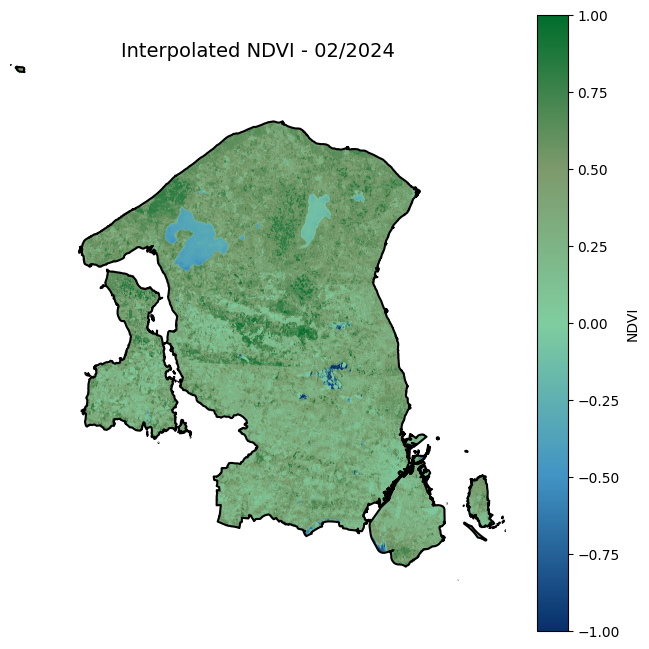

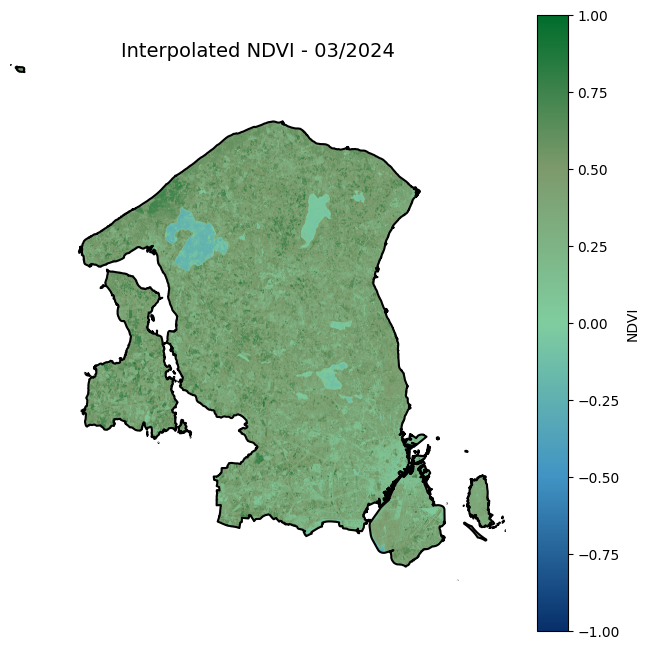

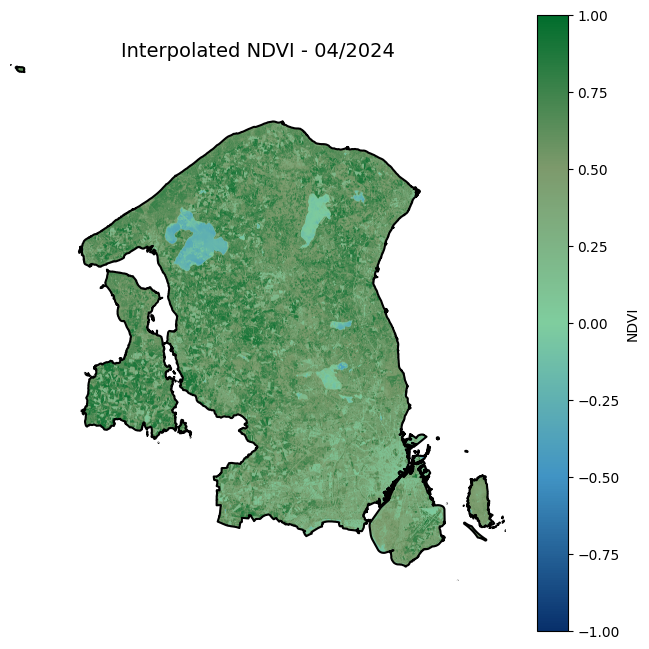

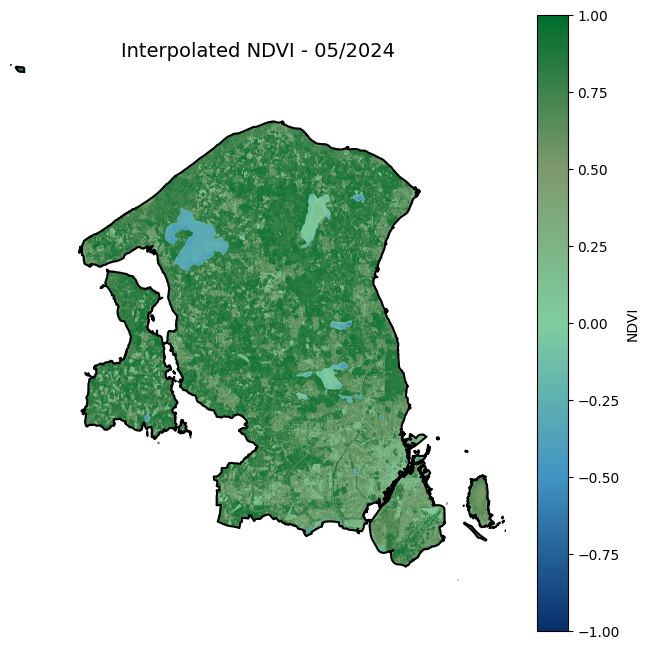

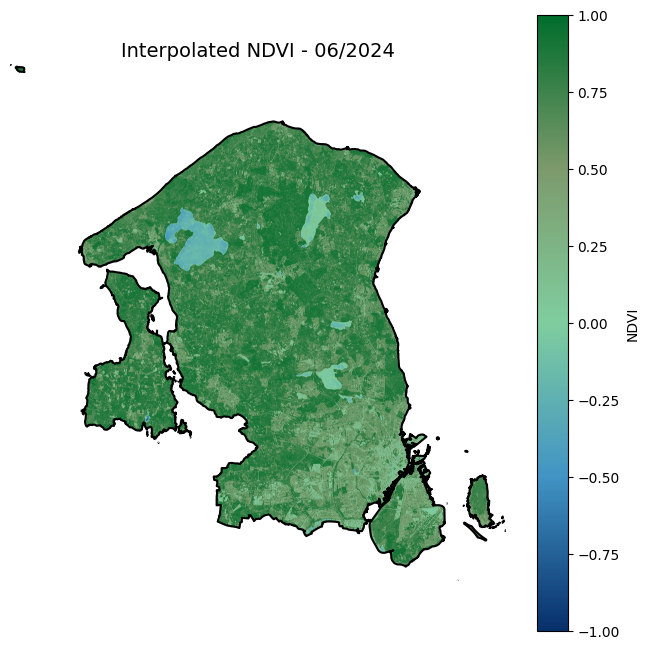

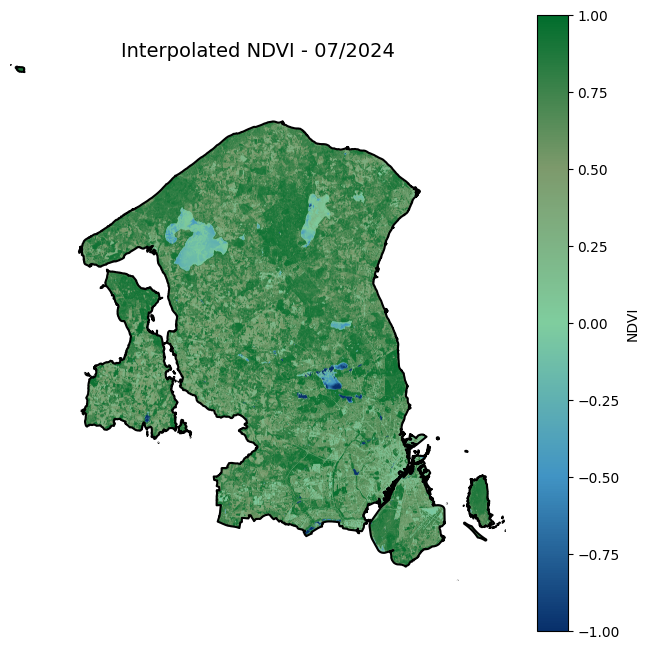

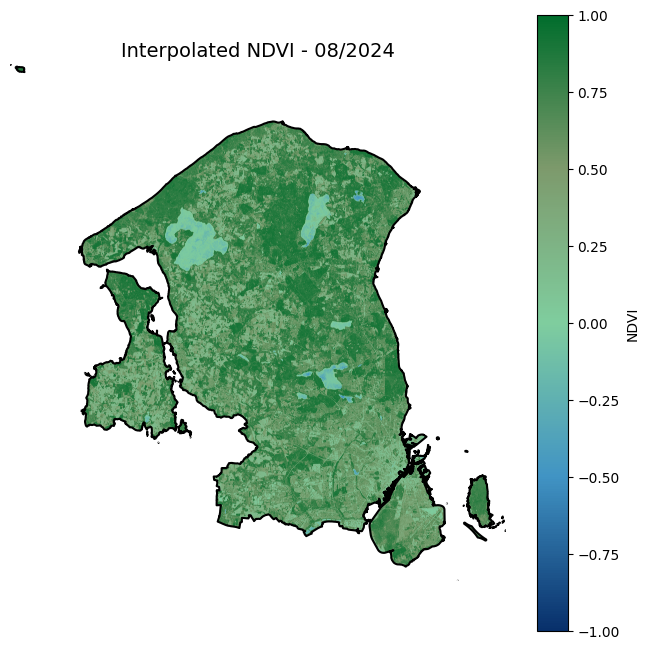

In [13]:
# --- PLOT INTERPOLATED NDVI STACK ---

colors = ["#08306B", "#4194C4", "#7FCD9E", "#7D9A6C", "#006D2C"]
blue_green = LinearSegmentedColormap.from_list("BlueGreen", colors)

# Load the first raster just to reuse the transform and metadata
with rasterio.open(tif_files[0]) as src:
    transform = src.transform
    crs = src.crs

# Plot each interpolated month
for i in range(len(ndvi_filled)):
    fig, ax = plt.subplots(figsize=(8, 8))

    img = ax.imshow(
        ndvi_filled[i],
        cmap=blue_green,
        vmin=-1,
        vmax=1,
        extent=[
            transform[2],
            transform[2] + transform[0] * ndvi_filled.shape[2],
            transform[5] + transform[4] * ndvi_filled.shape[1],
            transform[5],
        ],
    )

    cph.boundary.plot(ax=ax, edgecolor='black', linewidth=1.5)

    month_label = ndvi_files[i].split("_")[2].replace(".tif", "")
    year_label = ndvi_files[i].split("_")[1].replace(".tif", "")
    plt.title(f"Interpolated NDVI - {month_label}/{year_label}", fontsize=14)
    plt.colorbar(img, ax=ax, label='NDVI')
    plt.axis("off")
    plt.show()

    outpath = f"/home/s232713/figures/interpolated_NDVI_{year_label}_{month_label}.pdf"
    fig.savefig(
        outpath,
        format="pdf",
        bbox_inches="tight"
    )

    plt.close(fig)


In [12]:
# save the intepolated images
output_folder = "/mnt/raid/matteo/GEE_Exports_interpolated/"

os.makedirs(output_folder, exist_ok=True)

for i, tif_path in enumerate(tif_files):
    with rasterio.open(tif_path) as src:
        profile = src.profile

    profile.update(dtype=rasterio.float32, nodata=np.nan)

    filename = os.path.basename(tif_path).replace(".tif", "_interpolated.tif")
    output_path = os.path.join(output_folder, filename)

    with rasterio.open(output_path, "w", **profile) as dst:
        dst.write(ndvi_filled[i].astype(np.float32), 1)

    print(f"Saved: {output_path}")


Saved: /mnt/raid/matteo/GEE_Exports_interpolated/NDVI_2023_10_interpolated.tif
Saved: /mnt/raid/matteo/GEE_Exports_interpolated/NDVI_2023_11_interpolated.tif
Saved: /mnt/raid/matteo/GEE_Exports_interpolated/NDVI_2023_12_interpolated.tif
Saved: /mnt/raid/matteo/GEE_Exports_interpolated/NDVI_2024_01_interpolated.tif
Saved: /mnt/raid/matteo/GEE_Exports_interpolated/NDVI_2024_02_interpolated.tif
Saved: /mnt/raid/matteo/GEE_Exports_interpolated/NDVI_2024_03_interpolated.tif
Saved: /mnt/raid/matteo/GEE_Exports_interpolated/NDVI_2024_04_interpolated.tif
Saved: /mnt/raid/matteo/GEE_Exports_interpolated/NDVI_2024_05_interpolated.tif
Saved: /mnt/raid/matteo/GEE_Exports_interpolated/NDVI_2024_06_interpolated.tif
Saved: /mnt/raid/matteo/GEE_Exports_interpolated/NDVI_2024_07_interpolated.tif
Saved: /mnt/raid/matteo/GEE_Exports_interpolated/NDVI_2024_08_interpolated.tif


NEED TO VERIFY THIS INFORMATION: 

The cause: lack of valid Sentinel-2 data in that region and time
December over Denmark (or any high-latitude area) is not friendly for NDVI composites:
🌧️ Cloud cover → Sentinel-2’s cloud mask removes most pixels.
❄️ Snow cover / low sunlight → NIR and RED bands become unreliable.
🕶️ Low sun angle → invalid reflectance or “no data” values.
🗓️ Monthly composite window (e.g. 1–31 Dec) → if no clear pixels in that region, the mosaic leaves those pixels empty.
So that line marks the northern limit where at least one clear Sentinel-2 observation existed in December 2024.
Everything above it = 100 % cloudy/snowy → NaN.


Why it’s perfectly straight
It’s straight because it corresponds to the tile boundary or scene coverage edge of the Sentinel-2 orbit.
At these latitudes, each tile is roughly rectangular in UTM projection — so missing an entire tile creates a straight horizontal “cut”.
In November, you can already see the beginning of that — partial coverage or thin data in the same tile zone.
By December, that tile had no usable scenes at all → pure NaN band

In [13]:
print("NaN count before interpolation:", np.isnan(ndvi_stack).sum())
print("NaN count after interpolation:", np.isnan(ndvi_filled).sum())
print("Reduction in NaN count:", np.isnan(ndvi_stack).sum() - np.isnan(ndvi_filled).sum())


NaN count before interpolation: 661993100
NaN count after interpolation: 649239525
Reduction in NaN count: 12753575


NOw extract the max, min, mean, std NDVI value for every active hexagon

In [14]:
# Paths
grid_path = "/home/s232713/data/grid_data/cph_hexgrid.geojson" 
active_csv = "/home/s232713/data/grid_data/grid_to_trip.csv"
ndvi_folder = "/mnt/raid/matteo/GEE_Exports_interpolated/"

In [15]:
# Load 
grid = gpd.read_file(grid_path)
active = pd.read_csv(active_csv) 

# Filter only active hexagons
active_grid = grid[grid['GRID_ID'].isin(active['GRID_ID'])]
print(f"Active hexagons: {len(active_grid)}") #  active hexagon 12905


Active hexagons: 12920


In [16]:
with rasterio.open(tif_files[0]) as src:
    raster_crs = src.crs

print("NDVI CRS:", raster_crs)
print("Grid CRS before:", active_grid.crs)

# Reproject the grid to match NDVI raster
active_grid = active_grid.to_crs(raster_crs)
print("Grid CRS after:", active_grid.crs)


NDVI CRS: EPSG:4326
Grid CRS before: EPSG:25833
Grid CRS after: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


In [17]:
print(ndvi_filled)

[[[        nan  0.00053277 -0.00692841 ...         nan         nan
           nan]
  [        nan -0.0175146  -0.02635307 ...         nan         nan
           nan]
  [        nan  0.00237812  0.01155906 ...         nan         nan
           nan]
  ...
  [        nan         nan         nan ...         nan         nan
           nan]
  [        nan         nan         nan ...         nan         nan
           nan]
  [        nan         nan         nan ...         nan         nan
           nan]]

 [[        nan -0.05871212 -0.04435484 ...         nan         nan
           nan]
  [        nan -0.06643356 -0.02366345 ...         nan         nan
           nan]
  [        nan -0.02545455  0.0184874  ...         nan         nan
           nan]
  ...
  [        nan         nan         nan ...         nan         nan
           nan]
  [        nan         nan         nan ...         nan         nan
           nan]
  [        nan         nan         nan ...         nan         nan
      

In [18]:
tif_files = sorted(glob.glob(os.path.join(ndvi_folder, "NDVI_*.tif")))
tif_files.remove(tif_files[0]) # remove the first one: october 2023
tif_files.remove(tif_files[-1]) # remove the second one: september 2024
print(tif_files)

results = []

for tif_path in tif_files:
    month = os.path.basename(tif_path).split("_")[2].split(".")[0] 
    
    # Compute stats for each active hex
    stats = zonal_stats(
        active_grid,
        tif_path,
        stats=["min", "max", "mean", "std"],
        nodata=-1, # specify nodata value
        geojson_out=False,
        raster_out=False,
    )
    
    # Combine results into DataFrame
    df = pd.DataFrame(stats)
    df["GRID_ID"] = active_grid["GRID_ID"].values
    df["month"] = month
    results.append(df)

# Merge all months
ndvi_stats = pd.concat(results)


['/mnt/raid/matteo/GEE_Exports_interpolated/NDVI_2023_11_interpolated.tif', '/mnt/raid/matteo/GEE_Exports_interpolated/NDVI_2023_12_interpolated.tif', '/mnt/raid/matteo/GEE_Exports_interpolated/NDVI_2024_01_interpolated.tif', '/mnt/raid/matteo/GEE_Exports_interpolated/NDVI_2024_02_interpolated.tif', '/mnt/raid/matteo/GEE_Exports_interpolated/NDVI_2024_03_interpolated.tif', '/mnt/raid/matteo/GEE_Exports_interpolated/NDVI_2024_04_interpolated.tif', '/mnt/raid/matteo/GEE_Exports_interpolated/NDVI_2024_05_interpolated.tif', '/mnt/raid/matteo/GEE_Exports_interpolated/NDVI_2024_06_interpolated.tif', '/mnt/raid/matteo/GEE_Exports_interpolated/NDVI_2024_07_interpolated.tif']


In [19]:
ndvi_stats.head()
# print(ndvi_stats['month'].unique())
# print(ndvi_stats['GRID_ID'].nunique())

min       max      mean       std  GRID_ID month
0  0.124041  0.381725  0.247519  0.061338     8989    11
1  0.148465  0.315238  0.237597  0.039623     8990    11
2  0.124770  0.349815  0.250108  0.055484     8991    11
3  0.064782  0.405749  0.219113  0.075278     8992    11
4  0.012565  0.423355  0.199080  0.082871     8993    11

In [20]:
# save the ndvi stats to csv
ndvi_stats.to_csv("/home/s232713/data/NDVI/grid_ndvi.csv", sep=',', index=False)

now need to compute the ndvi max, min, mean and std NDVI values for every tarjectory REDOIOT AGAIN USEING DATETIME

In [21]:
traj_path = "/home/s232713/data/trajectories/FINAL_foot_data.pkl"

# Load pickle file
trajectories = pd.read_pickle(traj_path)

# Ensure it's a GeoDataFrame
if not isinstance(trajectories, gpd.GeoDataFrame):
    trajectories = gpd.GeoDataFrame(trajectories, geometry='geometry')

print("Trajectories loaded:", len(trajectories))
print("Columns:", trajectories.columns)

Trajectories loaded: 2018
Columns: Index(['Activity_concat', 'Mean_HR_cond', 'Mean_HR_cond_zscored',
       'RMSSD_activity_concat', 'RMSSD_50_points_timeframe',
       'pNN50_activity_concat', 'LF_activity_concat', 'HF_activity_concat',
       'LF_HF_ratio_activity_concat', 'RMSSD_activity_concat_50_points',
       ...
       'Motorcyclist_perc_Mapillary', 'Other Rider_perc_Mapillary',
       'Car_perc_Mapillary', 'Truck_perc_Mapillary', 'Bus_perc_Mapillary',
       'On Rails_perc_Mapillary', 'Motorcycle_perc_Mapillary',
       'Bicycle_perc_Mapillary', 'geometry', 'buffer'],
      dtype='object', length=513)


In [22]:
# Convert date to datetime format
trajectories['Start Time_x'] = pd.to_datetime(trajectories['Start Time_x'])

# Create column with year_month (e.g. "2024_03")
trajectories['ndvi_month'] = trajectories['Start Time_x'].dt.strftime("%Y_%m")
print(trajectories['ndvi_month'].unique())


['2023_11' '2023_12' '2024_01' '2024_02' '2024_03' '2024_04' '2024_05'
 '2024_06' '2024_07']


In [23]:
with rasterio.open(tif_files[0]) as src:
    ndvi_crs = src.crs

if trajectories.crs != ndvi_crs:
    trajectories = trajectories.to_crs(ndvi_crs)

In [24]:
ndvi_folder = "/mnt/raid/matteo/GEE_Exports_interpolated/"
tif_files = sorted(glob.glob(os.path.join(ndvi_folder, "NDVI_*_interpolated.tif")))

results = []

for tif in tif_files:
    # Extract month key from filename, e.g. "2024_03"
    month_key = "_".join(os.path.basename(tif).split("_")[1:3]).replace("_interpolated.tif", "")

    # Select trajectories from that same month
    subset = trajectories[trajectories['ndvi_month'] == month_key].copy()
    if subset.empty:
        continue

    print(f"Processing NDVI for {month_key} ({len(subset)} trajectories)...")

    # Compute zonal statistics for each trajectory
    stats = zonal_stats(
        subset,
        tif,
        stats=["min", "max", "mean", "std"],
        nodata=np.nan,
        all_touched=True,
        boundless=True
    )

    df_stats = pd.DataFrame(stats)
    df_stats['ndvi_month'] = month_key
    df_stats['Interval ID'] = subset['Interval ID'].values  # adjust if your ID column has another name

    results.append(df_stats)



Processing NDVI for 2023_11 (211 trajectories)...
Processing NDVI for 2023_12 (268 trajectories)...
Processing NDVI for 2024_01 (269 trajectories)...
Processing NDVI for 2024_02 (85 trajectories)...
Processing NDVI for 2024_03 (215 trajectories)...
Processing NDVI for 2024_04 (212 trajectories)...
Processing NDVI for 2024_05 (327 trajectories)...
Processing NDVI for 2024_06 (285 trajectories)...
Processing NDVI for 2024_07 (146 trajectories)...


In [25]:
traj_ndvi = pd.concat(results, ignore_index=True)
traj_ndvi.head()

min       max      mean       std ndvi_month  Interval ID
0 -0.186916  0.591943  0.039714  0.130624    2023_11       265109
1 -0.326087  0.787234  0.320769  0.231378    2023_11       266118
2  0.016327  0.331948  0.141205  0.060756    2023_11       266417
3 -0.235669  0.890308  0.381612  0.248670    2023_11       266600
4 -0.235669  0.909324  0.371918  0.320972    2023_11       266909

In [26]:
# creating the month and year column
# Split 'ndvi_month' into two columns: 'year' and 'month'
traj_ndvi[['year', 'month']] = traj_ndvi['ndvi_month'].str.split('_', expand=True)

traj_ndvi['year'] = traj_ndvi['year'].astype(int)
traj_ndvi['month'] = traj_ndvi['month'].astype(int)

print(traj_ndvi[['ndvi_month', 'year', 'month']].head())
print(traj_ndvi.dtypes)
print(traj_ndvi['year'].unique())
print(traj_ndvi['month'].unique())


  ndvi_month  year  month
0    2023_11  2023     11
1    2023_11  2023     11
2    2023_11  2023     11
3    2023_11  2023     11
4    2023_11  2023     11
min            float64
max            float64
mean           float64
std            float64
ndvi_month      object
Interval ID      int64
year             int64
month            int64
dtype: object
[2023 2024]
[11 12  1  2  3  4  5  6  7]


In [27]:
saving_path = "/home/s232713/data/NDVI/traj_ndvi.csv"
traj_ndvi.to_csv(saving_path, sep=',', index=False)
print(f'saved in: {saving_path}')

saved in: /home/s232713/data/NDVI/traj_ndvi.csv


# visualization

In [1]:
import pandas as pd 

df_ndvi = pd.read_csv('/home/s232713/data/NDVI/grid_ndvi.csv')
print(df_ndvi.columns.values)

['min' 'max' 'mean' 'std' 'GRID_ID' 'month']


In [4]:
len(df_ndvi['GRID_ID'].unique())

12920

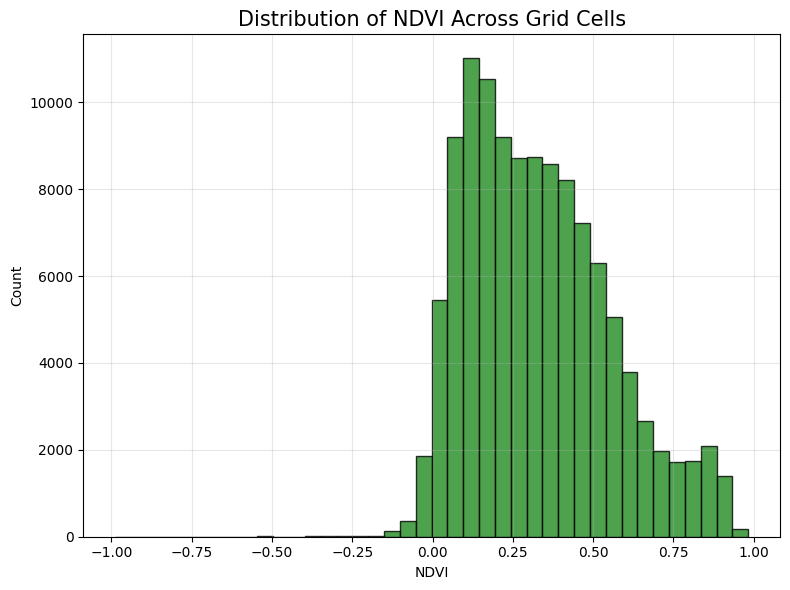

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.hist(df_ndvi["mean"].dropna(), bins=40, color="forestgreen", edgecolor="black", alpha=0.8)
plt.title("Distribution of NDVI Across Grid Cells", fontsize=15)
plt.xlabel("NDVI")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [13]:
print(df_ndvi['month'].unique())

[11 12  1  2  3  4  5  6  7]


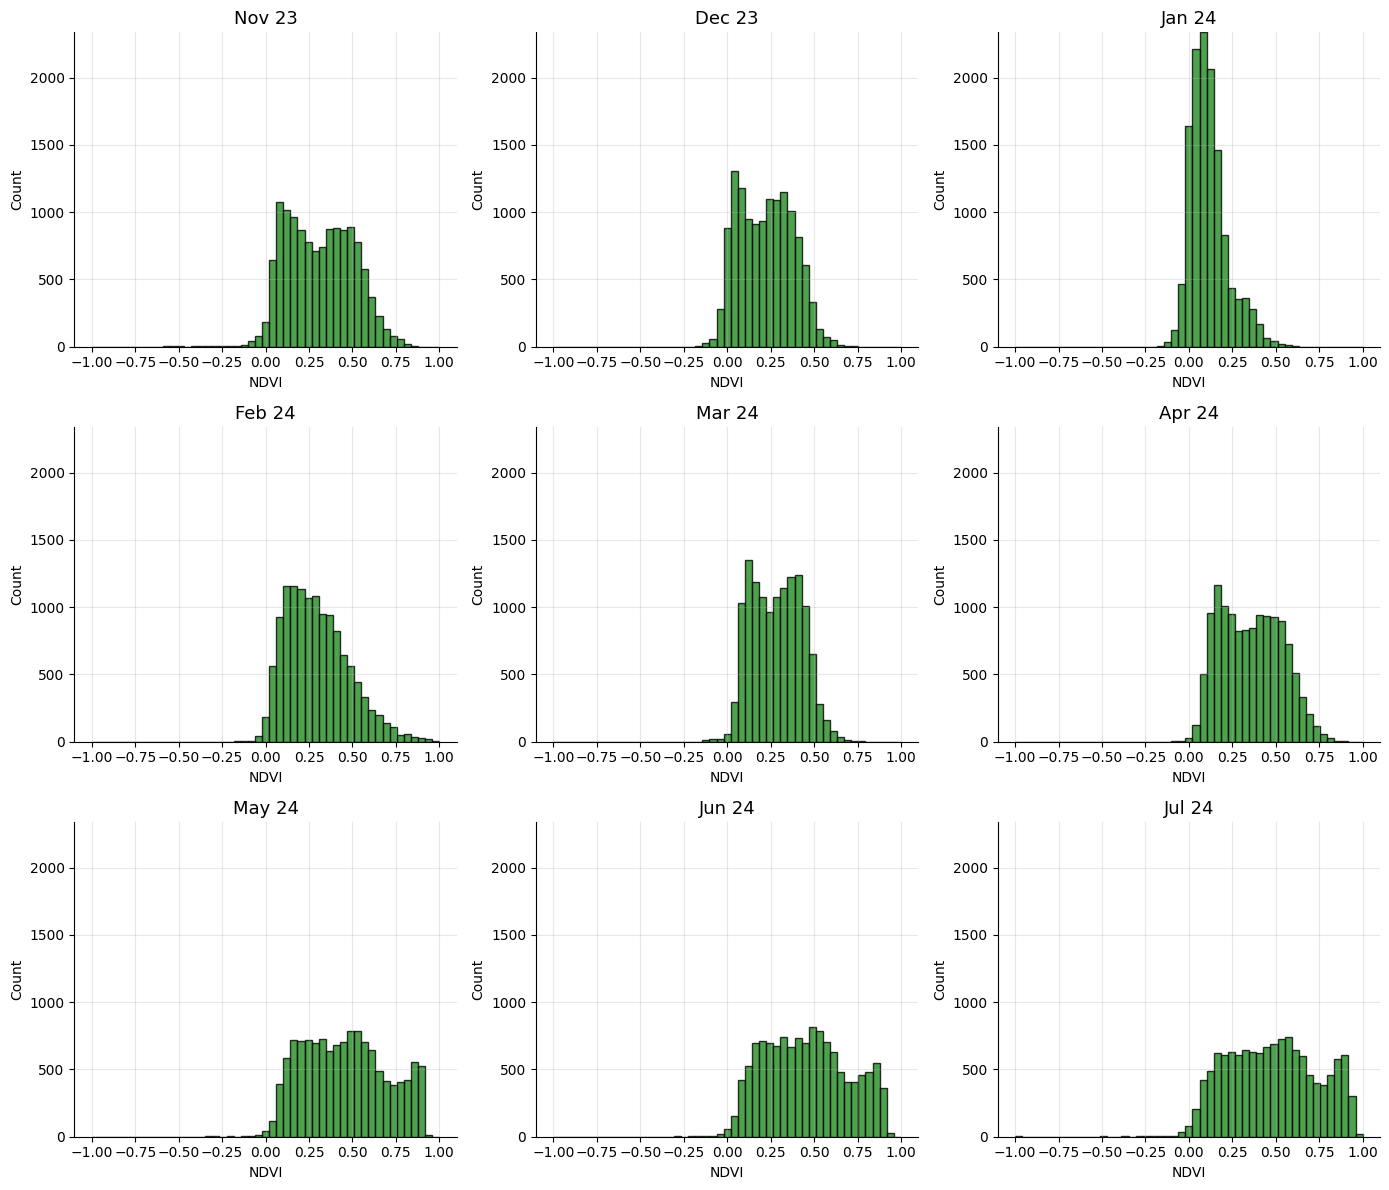

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# order months
order = [11, 12, 1, 2, 3, 4, 5, 6, 7]
labels = {
    11: "Nov 23",
    12: "Dec 23",
    1: "Jan 24",
    2: "Feb 24",
    3: "Mar 24",
    4: "Apr 24",
    5: "May 24",
    6: "Jun 24",
    7: "Jul 24"
}

df = df_ndvi[df_ndvi["month"].isin(order)]
df["month"] = pd.Categorical(df["month"], categories=order, ordered=True)

# find global max histogram count across all months
max_count = 0
bins = np.linspace(df["mean"].min(), df["mean"].max(), 30)

for m in order:
    counts, _ = np.histogram(df[df["month"] == m]["mean"].dropna(), bins=bins)
    max_count = max(max_count, counts.max())

# plot with unified y-scale
fig, axes = plt.subplots(3, 3, figsize=(14, 12))
axes = axes.flatten()

for i, month in enumerate(order):
    ax = axes[i]
    data = df[df["month"] == month]["mean"].dropna()

    ax.hist(data, bins=bins, color="forestgreen", edgecolor="black", alpha=0.8)
    ax.set_title(labels[month], fontsize=13)
    ax.set_xlabel("NDVI")
    ax.set_ylabel("Count")
    ax.set_ylim(0, max_count)  # unified scale
    ax.grid(alpha=0.3)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()



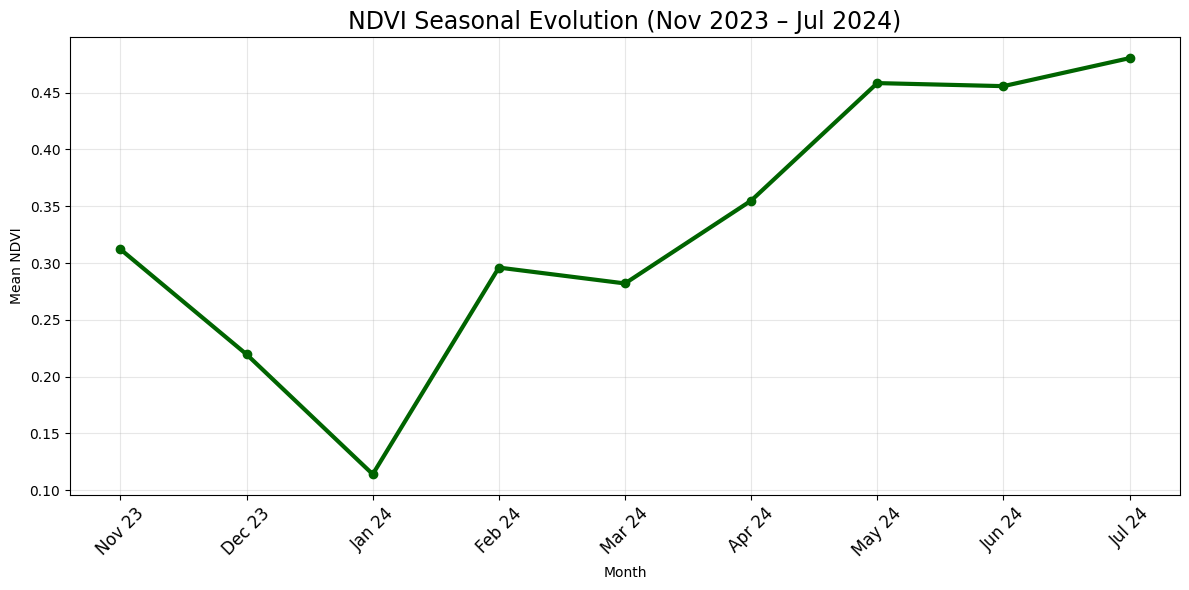

In [15]:
import matplotlib.pyplot as plt

# monthly NDVI averaged across grid cells
df_season = df_ndvi.groupby("month")["mean"].mean().reset_index()

# order months explicitly
order = [11, 12, 1, 2, 3, 4, 5, 6, 7]
df_season = df_season[df_season["month"].isin(order)]
df_season["month"] = pd.Categorical(df_season["month"], categories=order, ordered=True)
df_season = df_season.sort_values("month")

# pretty labels
labels = {
    11: "Nov 23",
    12: "Dec 23",
    1:  "Jan 24",
    2:  "Feb 24",
    3:  "Mar 24",
    4:  "Apr 24",
    5:  "May 24",
    6:  "Jun 24",
    7:  "Jul 24"
}
df_season["label"] = df_season["month"].map(labels)

# plot
plt.figure(figsize=(12,6))
plt.plot(
    df_season["label"],
    df_season["mean"],
    marker="o",
    color="darkgreen",
    linewidth=3
)

plt.title("NDVI Seasonal Evolution (Nov 2023 – Jul 2024)", fontsize=17)
plt.xlabel("Month")
plt.ylabel("Mean NDVI")
plt.grid(alpha=0.3)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()



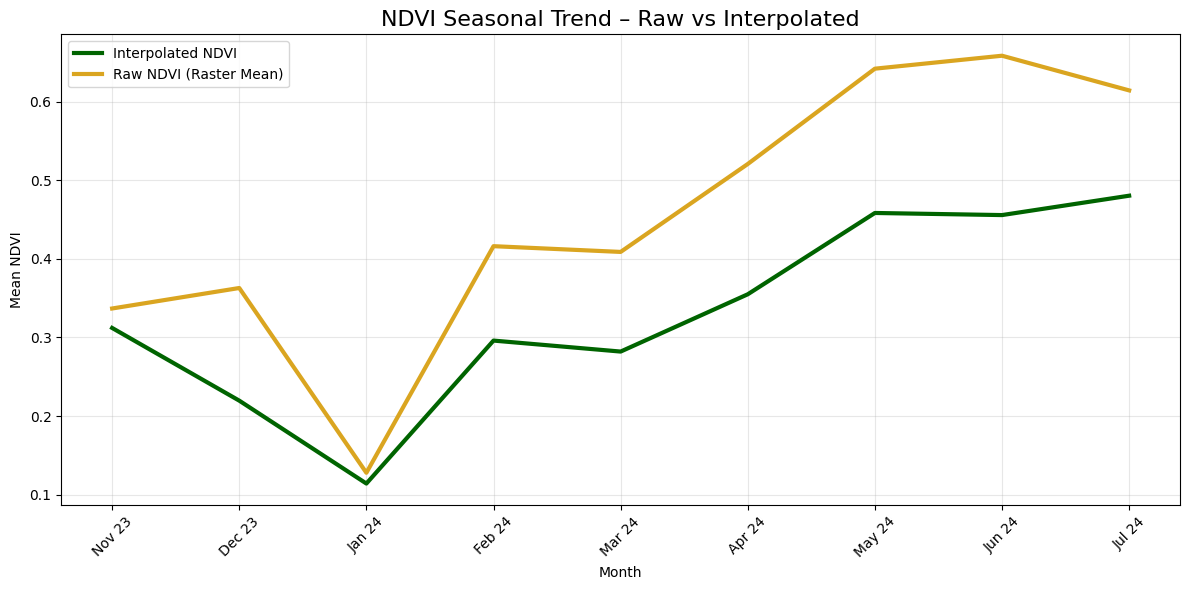

In [16]:
# df_ndvi contains: ['min','max','mean','std','GRID_ID','month']
# creation of interpolated values
df_season_interpolated = (
    df_ndvi.groupby("month")["mean"].mean().reset_index()
)

month_labels = {
    11: "Nov 23",
    12: "Dec 23",
    1:  "Jan 24",
    2:  "Feb 24",
    3:  "Mar 24",
    4:  "Apr 24",
    5:  "May 24",
    6:  "Jun 24",
    7:  "Jul 24"
}

df_season_interpolated["month_label"] = df_season_interpolated["month"].map(month_labels)


# creation of raw values from the raster stack
raw_months = []
raw_means = []
raw_labels = []

for arr, fname in zip(ndvi_stack, ndvi_files):
    base = fname.replace(".tif", "")
    _, y, m = base.split("_")  # NDVI_YYYY_MM
    y = int(y)
    m = int(m)

    # keep only months 11/2023 → 07/2024
    if (y, m) in [
        (2023,11),(2023,12),(2024,1),(2024,2),(2024,3),
        (2024,4),(2024,5),(2024,6),(2024,7)
    ]:
        values = arr.flatten()
        values = values[~np.isnan(values)]
        
        raw_months.append(m)
        raw_means.append(values.mean())
        raw_labels.append(f"{m:02d}/{y}")

df_season_raw = pd.DataFrame({
    "month": raw_months,
    "mean": raw_means,
    "month_label": raw_labels
})

# sort them in calendar order
df_season_raw = df_season_raw.sort_values("month")


timeline = [
    (2023, 11),
    (2023, 12),
    (2024, 1),
    (2024, 2),
    (2024, 3),
    (2024, 4),
    (2024, 5),
    (2024, 6),
    (2024, 7)
]

timeline_labels = [
    "Nov 23", "Dec 23", "Jan 24", "Feb 24", "Mar 24",
    "Apr 24", "May 24", "Jun 24", "Jul 24"
]
interp_map = df_season_interpolated.set_index("month")["mean"].to_dict()

interp_series = [interp_map.get(m, np.nan) for (y, m) in timeline]

# build raw series aligned to the same timeline
raw_map = df_season_raw.set_index("month")["mean"].to_dict()
raw_series = [raw_map.get(m, np.nan) for (y, m) in timeline]


plt.figure(figsize=(12,6))

plt.plot(
    timeline_labels,
    interp_series,
    label="Interpolated NDVI",
    linewidth=3,
    color="darkgreen"
)

plt.plot(
    timeline_labels,
    raw_series,
    label="Raw NDVI (Raster Mean)",
    linewidth=3,
    color="goldenrod"
)

plt.title("NDVI Seasonal Trend – Raw vs Interpolated", fontsize=16)
plt.xlabel("Month")
plt.ylabel("Mean NDVI")
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Raw NDVI computed directly from monthly Sentinel-2 composites is highly sensitive to cloud cover and missing data. Because only a subset of pixels is valid in winter, raw NDVI overestimates greenness during cloudy months. The interpolated NDVI smooths the spatial distribution and incorporates all grid cells, producing a more stable and ecologically meaningful seasonal pattern.